In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
# firing rate

device = 'cpu'



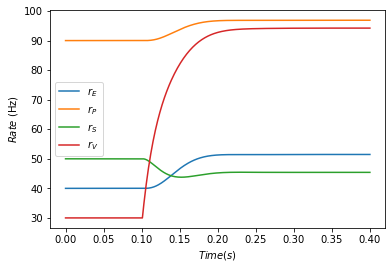

In [40]:
# Wee = 0.8 # NON_ISN
Wee = 1.2 # ISN
W = np.array([[Wee, -1, -1,  0], [1, -1, -0.5, 0], [1, 0, 0, -0.25], [1, 0, -0.6, 0]])

# parameters
N = 4

dt = 1e-3
tau = 20e-3 # s
I = np.eye(N)
m = 10
T = tau * I
r0 = m * np.array([4, 9, 5, 3])
B = m * np.array([0, 0, 0, 5])

t_range = np.arange(0.4/dt + 1)
T_stim = 0.1/dt

r = np.zeros([t_range.shape[0], r0.shape[0]])
dr = np.zeros([t_range.shape[0], r0.shape[0]])
dr_equilibrium = ([t_range.shape[0], r0.shape[0]])

r[0, :] = 0 + r0


for i, t in enumerate(t_range[0: - 1]):

    if t <= T_stim:
        b = np.zeros([W.shape[0]])
    else:
        b = B

    dr[i + 1, :] = np.matmul(np.linalg.inv(T), (np.matmul( (W - I), (r[i, :] - r0)) + b ))
    r[i + 1, :] = r[i, :] + dr[i + 1, :] * dt

dr_equilibrium = np.linalg.inv(W - I) * b

dI_I = np.sum( W[0, 1: ] * r[:, 1: ], 1)
dI_I = -(dI_I - dI_I[0])
dI_E = W[0, 0] * r[:, 0]
dI_E = dI_E - dI_E[0]

for i in range(r0.shape[0]):
    plt.plot(t_range * dt, r[:, i])
plt.xlabel('$Time (s)$')
plt.ylabel('$Rate$ (Hz)')
plt.legend(['$r_E$', '$r_P$', '$r_S$', '$r_V$'])
plt.show()

hidden_trace = np.zeros([4, t_range.shape[0]])
hidden_trace[0, :] = np.random.poisson(r[:, 0] * dt)
hidden_trace[1, :] = np.random.poisson(r[:, 1] * dt)
hidden_trace[2, :] = np.random.poisson(r[:, 2] * dt)
hidden_trace[3, :] = np.random.poisson(r[:, 3] * dt)
hidden_trace[hidden_trace < 0] = 0
hidden_trace[hidden_trace > 1] = 1

hidden_trace = torch.tensor(hidden_trace, dtype=torch.float, device=device)


In [41]:

def generate_data(W, B = np.array([0, 0, 0, 5])):

    # parameters
    N = 4

    dt = 1e-3
    tau = 20e-3 # s
    I = np.eye(N)
    m = 10
    T = tau * I
    r0 = m * np.array([4, 9, 5, 3])
    B = m * B

    t_range = np.arange(0.15/dt + 1)
    T_stim = 0#0.05/dt

    r = np.zeros([t_range.shape[0], r0.shape[0]])
    dr = np.zeros([t_range.shape[0], r0.shape[0]])
    dr_equilibrium = ([t_range.shape[0], r0.shape[0]])

    r[0, :] = 0 + r0


    for i, t in enumerate(t_range[0: - 1]):

        if t <= T_stim:
            b = np.zeros([W.shape[0]])
        else:
            b = B

        dr[i + 1, :] = np.matmul(np.linalg.inv(T), (np.matmul( (W - I), (r[i, :] - r0)) + b ))
        r[i + 1, :] = r[i, :] + dr[i + 1, :] * dt

    hidden_trace = np.zeros([4, t_range.shape[0]])
    hidden_trace[0, :] = np.random.poisson(r[:, 0] * dt)
    hidden_trace[1, :] = np.random.poisson(r[:, 1] * dt)
    hidden_trace[2, :] = np.random.poisson(r[:, 2] * dt)
    hidden_trace[3, :] = np.random.poisson(r[:, 3] * dt)
    hidden_trace[hidden_trace < 0] = 0
    hidden_trace[hidden_trace > 1] = 1

    hidden_trace = torch.tensor(hidden_trace, dtype=torch.float, device=device)

    return hidden_trace

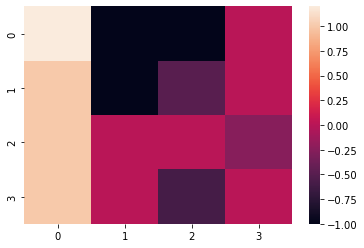

tensor(28.)

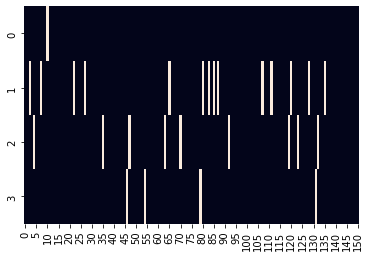

In [42]:
# Wee = 0.8 # NON_ISN
Wee = 1.2 # ISN
W = np.array([[Wee, -1, -1,  0], [1, -1, -0.5, 0], [1, 0, 0, -0.25], [1, 0, -0.6, 0]])

B = np.zeros(4)
B[0] = np.random.randint(low=0, high=5)
B[3] = np.random.randint(low=0, high=5)

hidden_trace = generate_data(W, B)
sns.heatmap(W)
plt.show()
sns.heatmap(hidden_trace, cbar=False)
torch.sum(hidden_trace)


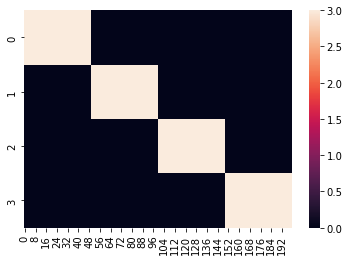

tensor(0.5290)

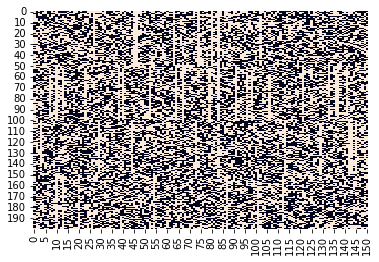

In [47]:
n_batches = 120
N_H, T = hidden_trace.shape
N_V = 50 * N_H
spikes = torch.zeros([N_V, T, n_batches])

VH = 0 * torch.rand([N_H, N_V])
for i in range(N_H):
    VH[i, i*50 : (i+1)*50] = 3 * torch.ones([1, 50])
sns.heatmap(VH)
plt.show()

rtrbm_sample = RTRBM(torch.zeros([N_V, T, n_batches]), N_H = 4, device=device)
rtrbm_sample.W = VH

for batch in range(n_batches):
    B = np.zeros(4)
    B[0] = np.random.randint(low=0, high=5)
    hidden_trace = generate_data(W, B)
    spikes[:, :, batch] = torch.bernoulli(torch.sigmoid(torch.matmul(VH.T, hidden_trace) + 0))

sns.heatmap(spikes[:, :, 0], cbar=False)
torch.mean(spikes)

In [ ]:
rtrbm = RTRBM(spikes, N_H=4, device='cpu')
rtrbm.learn(n_epochs=1500, batchsize=10, lr=1e-3, lr_end=1e-5, start_decay=200)
plt.plot(rtrbm.errors)


 58%|█████▊    | 875/1500 [48:16<36:32,  3.51s/it]  

In [ ]:
corr = np.zeros((N_H, N_H))
shuffle_idx = np.zeros((N_H))
for i in range(N_H):
    for j in range(N_H):
        corr[i, j] = np.correlate(rtrbm_sample.W[i,:], rtrbm.W[j,:])
    shuffle_idx[i] = np.argmax(corr[i,:])

W_train = rtrbm.W[shuffle_idx, :].clone()
W_acc_train = rtrbm.U[shuffle_idx, :].clone()
W_acc_train = rtrbm.U[:, shuffle_idx].clone()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.heatmap(W_train, ax=ax[0, 0])
sns.heatmap(W_acc_train, ax=ax[0, 1])
sns.heatmap(torch.matmul(W_acc_train.T, W_acc_train), ax=ax[1, 0])
sns.heatmap(W, ax=ax[1,1])
plt.show